# NYSE & Blurr

In this walkthrough guide we will train a machine learning model that predicts closing price of a stock based on historical data. We will transform time-series stock data into features to train this model. 


## Preparation

Let's start by installing importing `Blurr`, `pandas` and other required dependencies:

In [1]:
import sys

!{sys.executable} -m pip uninstall blurr-dev --yes &> /dev/null

print("installing blurr...")
!{sys.executable} -m pip install blurr-dev --quiet
!{sys.executable} -m pip --version

installing blurr...
pip 9.0.1 from /opt/conda/lib/python3.6/site-packages (python 3.6)


In [2]:
import pandas as pd
from blurr_util import print_head, validate, transform

def print_file(file):
    with open(file, 'r') as f:
        data = f.read()
    print(data)

## The Dataset

This walkthrough is based on [New York Stock Exchange Data](https://www.kaggle.com/dgawlik/nyse/data) made available for [Kaggle challenges](https://www.kaggle.com/dgawlik/nyse).

Let's have a peek at the available data: 

In [4]:
stocks = pd.read_json("./data/prices-split-adjusted.json", lines=True)
stocks.head()

,close,date,high,low,open,symbol,volume
0,125.839996,2016-01-05,126.250000,122.309998,123.430000,WLTW,2163600
1,119.980003,2016-01-06,125.540001,119.940002,125.239998,WLTW,2386400
2,114.949997,2016-01-07,119.739998,114.930000,116.379997,WLTW,2489500
3,116.620003,2016-01-08,117.440002,113.500000,115.480003,WLTW,2006300
4,114.970001,2016-01-11,117.330002,114.089996,117.010002,WLTW,1408600


This dataset contains data for each market day.

Our **goal is to predict closing price** of a stock for any given day based on historical data. In order to do that, we need to transform our original data source into features that can be used for training.

We'll calculate **moving averages** and other aggregate data for different **time windows**: one, three and seven days.

## Blurr Templates

We perform initial transformation of our data with [nyse-streaming-dtc.yml](./nyse-streaming-dtc.yml). Data is then aggregated by time using [nyse-window-dtc.yml](./nyse-window-dtc.yml).

In [5]:
print_file('nyse-streaming-dtc.yml')

Type: 'Blurr:Transform:Streaming'
Version: '2018-03-01'
Description: New York Store Exchange Transformations
Name: nyse

Import:
  - { Module: datetime, Identifiers: [ datetime ] }

Identity: source.symbol

Time: datetime.strptime(source.date, '%Y-%m-%d')

Stores:
  - Type: 'Blurr:Store:Memory'
    Name: memory

Aggregates:
  - Type: 'Blurr:Aggregate:Block'
    Name: stats
    Store: memory
    Split: True
    When: source.symbol in ['AAPL', 'MSFT', 'GOOG', 'FB']
    Fields:
      - Name: close
        Type: float
        Value: source.close

      - Name: volatility
        Type: float
        Value: (float(source.high) / float(source.low)) - 1

      - Name: volume
        Type: float
        Value: source.volume


**Streaming DTC**

We're predicting values for tech companies only (Apple, Facebook, Microsoft, Google):

```yaml
When: source.symbol in ['AAPL', 'MSFT', 'GOOG', 'FB']
```

Each record in the original dataset represents a single day, which is the same we need to feed our window transformation. By setting `Split: True` we'll create a new aggregate for each single dataset record.


In [6]:
print_file('nyse-window-dtc.yml')

Type: Blurr:Transform:Window
Version: '2018-03-01'
Name: moving_averages

SourceDTC: nyse

Anchor:
  Condition: nyse.stats.volatility < 0.04

Aggregates:


  - Type: Blurr:Aggregate:Window
    Name: close
    WindowType: count
    WindowValue: 1
    Source: nyse.stats
    Fields:
    - Name: value
      Type: float
      Value: anchor.close

  - Type: Blurr:Aggregate:Window
    Name: last
    WindowType: count
    WindowValue: -1
    Source: nyse.stats
    Fields:
    - Name: close
      Type: float
      Value: source.close[0]
    - Name: volume
      Type: float
      Value: source.volume[0]
    - Name: volatility
      Type: float
      Value: source.volatility[0]

  - Type: Blurr:Aggregate:Window
    Name: last_3
    WindowType: count
    WindowValue: -3
    Source: nyse.stats
    Fields:
    - Name: close_avg
      Type: float
      Value: sum(source.close) / len(source.close)
    - Name: volume_avg
      Type: float
      Value: sum(source.volume) / len(source.volume)
    - Name:

**Window DTC**

We'll use a very rough criteria to remove outliers: our model will only work when closing price changes less than a 4%:

```yaml
Anchor:
  Condition: nyse.stats.volatility < 0.04
```

We're using [moving averages](https://www.investopedia.com/terms/m/movingaverage.asp) to generate features based on historical data about a stock:

```yaml
- Type: Blurr:Aggregate:Window
    Name: last_7
    WindowType: count
    WindowValue: -7
    Source: nyse.stats
    Fields:
    - Name: close_avg
      Type: float
      Value: sum(source.close) / len(source.close)
```


## Transforming Data



In [7]:
validate('nyse-streaming-dtc.yml')
validate('nyse-window-dtc.yml')

Running syntax validation on nyse-streaming-dtc.yml
Document is valid
Running syntax validation on nyse-window-dtc.yml
Document is valid


Let's run our Streaming DTC only for informational purposes only, so we can preview the result of the transformation:

In [8]:
transform(log_files=["./data/prices-split-adjusted.json"],
          stream_dtc='./nyse-streaming-dtc.yml',
          output_file="./nyse-streaming-dtc-out.log")

In [9]:
print_head("./nyse-streaming-dtc-out.log")

In [10]:
transform(log_files=["./data/prices-split-adjusted.json"],
          stream_dtc='./nyse-streaming-dtc.yml',
          window_dtc='./nyse-window-dtc.yml',
          output_file="./nyse-processed-data.csv")

Let's now preview the data that will be used to **train our model**

In [11]:
window_out = pd.read_csv("./nyse-processed-data.csv")
window_out.head()

,close._identity,close.value,last._identity,last.close,last.volatility,last.volume,last_3._identity,last_3.close_avg,last_3.max_volatility,last_3.min_volatility,last_3.volatility_avg,last_3.volume_avg,last_7._identity,last_7.close_avg,last_7.max_volatility,last_7.min_volatility,last_7.volatility_avg,last_7.volume_avg
0,AAPL,30.092857,AAPL,29.674286,0.016229,148614900.0,AAPL,29.990953,0.021828,0.014063,0.017373,1.253583e+08,AAPL,30.198979,0.021828,0.009982,0.015492,129615200.0
1,AAPL,29.918571,AAPL,30.092857,0.033464,151473000.0,AAPL,29.927619,0.033464,0.016229,0.023840,1.385484e+08,AAPL,30.130408,0.033464,0.010973,0.018847,133621000.0
2,AAPL,29.418571,AAPL,29.918571,0.006889,108223500.0,AAPL,29.895238,0.033464,0.006889,0.018861,1.361038e+08,AAPL,30.029388,0.033464,0.006889,0.018263,127584900.0
3,AAPL,30.719999,AAPL,29.418571,0.027833,148516900.0,AAPL,29.810000,0.033464,0.006889,0.022729,1.360711e+08,AAPL,29.926531,0.033464,0.006889,0.019203,129081600.0
4,AAPL,30.247143,AAPL,30.719999,0.038361,182501900.0,AAPL,30.019047,0.038361,0.006889,0.024361,1.464141e+08,AAPL,30.017551,0.038361,0.006889,0.022667,138112900.0


## Modelling

We need to install Tensorflow and import all required dependencies:

In [12]:
!{sys.executable} -m pip install tensorflow --quiet

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

Using TensorFlow backend.


### Reading Source Data

We next read data into a DataFrame. We're dropping unnecessary `_identity` columns and then applying a MinMax normalization:

In [13]:
def read_source_df():
    data = pd.read_csv("./nyse-processed-data.csv")
    data["adj close"] = data["close.value"] # Moving close to the last column
    data.drop(['close.value'], 1, inplace=True) 
    data.drop(['close._identity'], 1, inplace=True) 
    data.drop(['last._identity'], 1, inplace=True) 
    data.drop(['last_3._identity'], 1, inplace=True) 
    data.drop(['last_7._identity'], 1, inplace=True) 
    return data

df = read_source_df()
df.head()

,last.close,last.volatility,last.volume,last_3.close_avg,last_3.max_volatility,last_3.min_volatility,last_3.volatility_avg,last_3.volume_avg,last_7.close_avg,last_7.max_volatility,last_7.min_volatility,last_7.volatility_avg,last_7.volume_avg,adj close
0,29.674286,0.016229,148614900.0,29.990953,0.021828,0.014063,0.017373,1.253583e+08,30.198979,0.021828,0.009982,0.015492,129615200.0,30.092857
1,30.092857,0.033464,151473000.0,29.927619,0.033464,0.016229,0.023840,1.385484e+08,30.130408,0.033464,0.010973,0.018847,133621000.0,29.918571
2,29.918571,0.006889,108223500.0,29.895238,0.033464,0.006889,0.018861,1.361038e+08,30.029388,0.033464,0.006889,0.018263,127584900.0,29.418571
3,29.418571,0.027833,148516900.0,29.810000,0.033464,0.006889,0.022729,1.360711e+08,29.926531,0.033464,0.006889,0.019203,129081600.0,30.719999
4,30.719999,0.038361,182501900.0,30.019047,0.038361,0.006889,0.024361,1.464141e+08,30.017551,0.038361,0.006889,0.022667,138112900.0,30.247143


In [14]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    for column in df:
        df[column] = min_max_scaler.fit_transform(df[column].values.reshape(-1,1))
    return df

df = normalize_data(df)
df.head()

,last.close,last.volatility,last.volume,last_3.close_avg,last_3.max_volatility,last_3.min_volatility,last_3.volatility_avg,last_3.volume_avg,last_7.close_avg,last_7.max_volatility,last_7.min_volatility,last_7.volatility_avg,last_7.volume_avg,adj close
0,0.008573,0.136157,0.316018,0.008853,0.054455,0.201752,0.085975,0.323094,0.008550,0.043794,0.201177,0.121629,0.415200,0.009015
1,0.009102,0.325537,0.322096,0.008772,0.094569,0.244491,0.133054,0.357095,0.008462,0.084360,0.233622,0.169251,0.428119,0.008794
2,0.008882,0.033530,0.230123,0.008731,0.094569,0.060209,0.096804,0.350794,0.008332,0.084360,0.099912,0.160969,0.408652,0.008161
3,0.008249,0.263664,0.315810,0.008622,0.094569,0.060209,0.124962,0.350709,0.008200,0.084360,0.099912,0.174304,0.413479,0.009808
4,0.009896,0.379350,0.388082,0.008889,0.111452,0.060209,0.136846,0.377372,0.008317,0.101433,0.099912,0.223483,0.442605,0.009210


### Building the model

In [15]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [16]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [17]:
window = 22
X_train, y_train, X_test, y_test = load_data(df, window)
print (X_train[0], y_train[0])

[[0.00857277 0.13615713 0.31601844 0.00885281 0.05445501 0.20175198
  0.08597492 0.32309379 0.00855009 0.04379389 0.20117653 0.12162913
  0.41519997 0.00901468]
 [0.00910246 0.32553734 0.32209642 0.00877199 0.09456897 0.24449068
  0.13305359 0.35709534 0.00846199 0.08436013 0.23362221 0.16925068
  0.42811888 0.0087941 ]
 [0.00888191 0.03353024 0.23012291 0.00873067 0.09456897 0.0602086
  0.09680371 0.35079354 0.0083322  0.08436013 0.09991156 0.16096873
  0.40865214 0.0081613 ]
 [0.00824916 0.2636643  0.31581003 0.0086219  0.09456897 0.0602086
  0.1249622  0.35070934 0.00820004 0.08436013 0.09991156 0.17430432
  0.41347908 0.00980839]
 [0.0098961  0.37934987 0.38808184 0.00888866 0.11145169 0.0602086
  0.13684608 0.37737152 0.00831699 0.1014332  0.09991156 0.22348327
  0.44260549 0.00920994]
 [0.00929771 0.27514862 0.32542494 0.00902842 0.11145169 0.47344906
  0.19020473 0.41587942 0.00831043 0.1014332  0.09991156 0.25352885
  0.46155751 0.00854821]
 [0.00677035 0.53410046 0.46876427 0.

In [18]:
model = build_model([len(df.columns), window,1]) # 14 is number of features??

Compilation Time :  0.021618127822875977


### Training 

In [19]:
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 4824 samples, validate on 536 samples
Epoch 1/90
4824/4824 [==============================] - 11s 2ms/step - loss: 0.0696 - acc: 2.0730e-04 - val_loss: 4.7455e-04 - val_acc: 0.0019
Epoch 2/90
4824/4824 [==============================] - 10s 2ms/step - loss: 0.0077 - acc: 2.0730e-04 - val_loss: 7.0672e-04 - val_acc: 0.0019
Epoch 3/90
4824/4824 [==============================] - 10s 2ms/step - loss: 0.0049 - acc: 2.0730e-04 - val_loss: 4.5533e-04 - val_acc: 0.0019
Epoch 4/90
4824/4824 [==============================] - 10s 2ms/step - loss: 0.0035 - acc: 2.0730e-04 - val_loss: 1.8529e-04 - val_acc: 0.0019
Epoch 5/90
4824/4824 [==============================] - 10s 2ms/step - loss: 0.0024 - acc: 2.0730e-04 - val_loss: 8.0141e-04 - val_acc: 0.0019
Epoch 6/90
4824/4824 [==============================] - 10s 2ms/step - loss: 0.0021 - acc: 2.0730e-04 - val_loss: 5.4182e-04 - val_acc: 0.0019
Epoch 7/90
4824/4824 [==============================] - 10s 2ms/step - loss: 0.0020 - acc: 2.07

Epoch 57/90
4824/4824 [==============================] - 10s 2ms/step - loss: 8.2748e-04 - acc: 2.0730e-04 - val_loss: 3.1792e-05 - val_acc: 0.0019
Epoch 58/90
4824/4824 [==============================] - 10s 2ms/step - loss: 8.9650e-04 - acc: 2.0730e-04 - val_loss: 2.3480e-05 - val_acc: 0.0019
Epoch 59/90
4824/4824 [==============================] - 10s 2ms/step - loss: 7.5818e-04 - acc: 2.0730e-04 - val_loss: 2.6155e-05 - val_acc: 0.0019
Epoch 60/90
4824/4824 [==============================] - 10s 2ms/step - loss: 6.4355e-04 - acc: 2.0730e-04 - val_loss: 3.9931e-05 - val_acc: 0.0019
Epoch 61/90
4824/4824 [==============================] - 10s 2ms/step - loss: 6.9218e-04 - acc: 2.0730e-04 - val_loss: 2.6625e-05 - val_acc: 0.0019
Epoch 62/90
4824/4824 [==============================] - 10s 2ms/step - loss: 7.0305e-04 - acc: 2.0730e-04 - val_loss: 2.4278e-05 - val_acc: 0.0019
Epoch 63/90
4824/4824 [==============================] - 10s 2ms/step - loss: 7.6190e-04 - acc: 2.0730e-04 - val

### Model Evaluation

In [25]:
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

(595, 1)


In [21]:
df = read_source_df()

def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [22]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00028 MSE (0.02 RMSE)
Test Score: 0.00002 MSE (0.00 RMSE)


(0.00027845214715636023, 1.8041758827900342e-05)

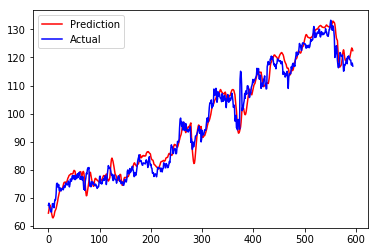

In [23]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()